In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model  import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn import datasets
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [2]:
# This function was only used to create the submission file for each time I submitted a prediction to Kaggle.
def sumbission_ready(prediction,prediction_number):
    #prediction = np.where(prediction==-1,0,1)
    prediction = pd.DataFrame(prediction, columns=['Predicted'])
    prediction.index.names = ['Id']
    prediction.to_csv(f'prediction_{prediction_number}.zip')
    prediction.to_csv(f'prediction_{prediction_number}')

In [82]:
# Import dataset and test set
raw_training_data = pd.read_csv('train.csv')
raw_test_data = pd.read_csv('test.csv')
print(raw_training_data.shape) # (2489, 7)
print(raw_test_data.shape) # (1660, 6)

(2489, 7)
(1660, 6)


In [83]:
raw_training_data.head(10) 
# There are NaN-values that must be dealt with some way.

,radiation_level,pressure,alien_prob,flare_prob,growth_potential,h2o,target
0,57.500,0.410000,9.300,14.9500,3.000,0,non_habitable
1,53.430,0.580000,1.500,12.6850,2.900,0,non_habitable
2,65.375,0.460000,3.922,13.4600,2.541,0,non_habitable
3,60.884,0.742000,14.361,12.3385,NaN,0,non_habitable
4,72.625,0.968000,3.323,9.3230,4.144,1,very_habitable
5,172.000,0.857000,9.000,10.8000,4.400,1,potentially_habitable
6,36.531,0.912000,2.443,3.7580,4.746,1,potentially_habitable
7,59.810,0.565000,3.900,10.8500,3.200,0,non_habitable
8,63.250,0.620448,10.200,10.5000,3.326,0,non_habitable
9,67.063,0.415000,2.877,14.0170,2.941,0,non_habitable


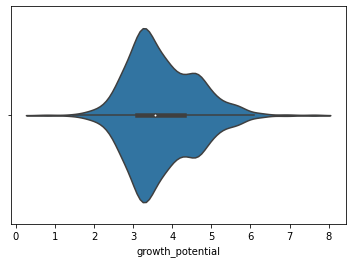

In [84]:
sns.violinplot(raw_training_data['growth_potential'])
plt.show()
# There could be possible to use the mean value to replace the NaN values. 
# I tried to remove the entire feature, but this gave worse performance overall. 
# Therefore i opted to use the mean as a replacemeant instead.
# By looking at this plot it is evident that the spread is reasonable so that the mean value will probably be representative.

In [85]:
raw_training_data.isna().sum()
# growth_potential has 543 NaN-values. This is problematic. 
# We can delete all the instances, but this removes roughly one third of the dataset.

# I tried to remove the nan-instances, and this gave worse acccuracy.

radiation_level       0
pressure              0
alien_prob            0
flare_prob            0
growth_potential    543
h2o                   0
target                0
dtype: int64

In [86]:
# Divide the training set into X and y. 

X = raw_training_data.iloc[:, :6]
y = raw_training_data.iloc[:, -1]
X_test_data = raw_test_data.iloc[:, :6]
print(y) # I see that y are listed as strings instead of values.

0               non_habitable
1               non_habitable
2               non_habitable
3               non_habitable
4              very_habitable
                ...          
2484            non_habitable
2485            non_habitable
2486           very_habitable
2487    potentially_habitable
2488            non_habitable
Name: target, Length: 2489, dtype: object


In [87]:
# I remove NaN-values from train and test so that the classifiers can run.

X['growth_potential'] = X['growth_potential'].fillna(np.mean(X['growth_potential']))
X_test_data['growth_potential'] = X_test_data['growth_potential'].fillna(np.mean(X['growth_potential']))
print(X.isna().sum()) 
print(X_test_data.isna().sum()) # No longer NaN values.

radiation_level     0
pressure            0
alien_prob          0
flare_prob          0
growth_potential    0
h2o                 0
dtype: int64
radiation_level     0
pressure            0
alien_prob          0
flare_prob          0
growth_potential    0
h2o                 0
dtype: int64


In [88]:
# I change the lables to values.

le = LabelEncoder()
y = le.fit_transform(y)

le.classes_
print(y) # y is now values instead of labels.

[0 0 0 ... 2 1 0]


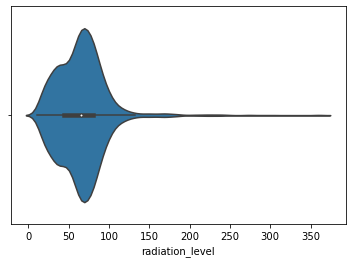

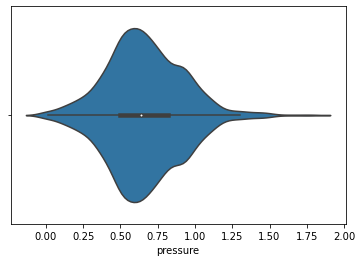

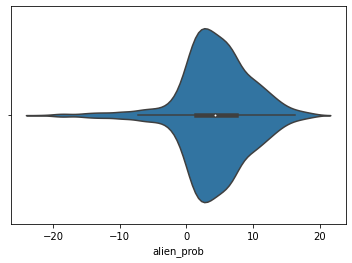

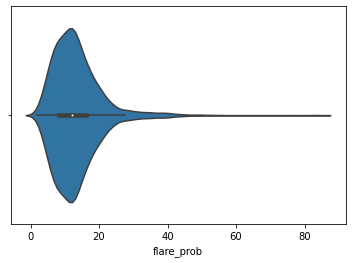

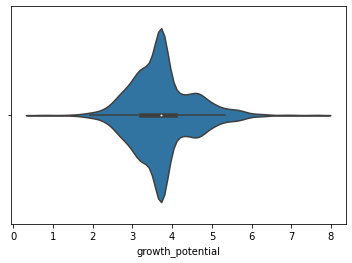

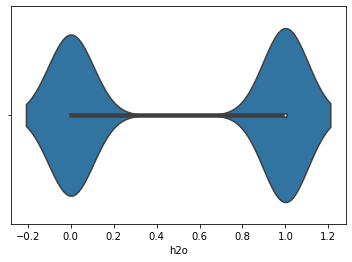

In [89]:
for column in X:
    plt.figure()
    ax = sns.violinplot(x=X[column])

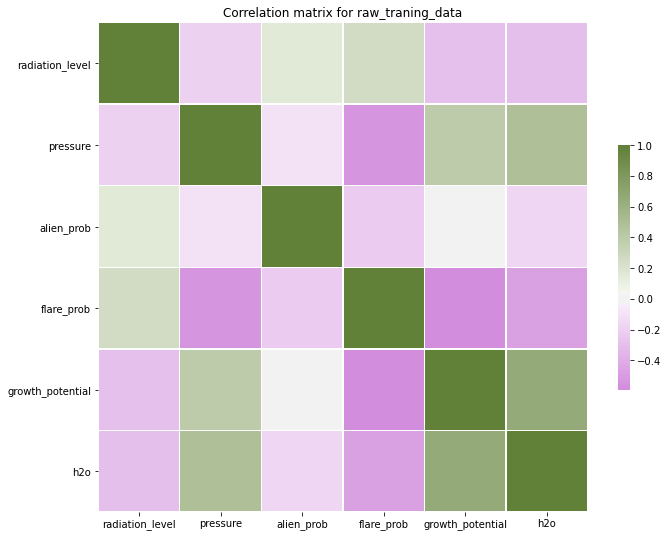

In [90]:
# Correlation matrix to inspect features.

corr = raw_training_data.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(300, 110, as_cmap=True)
plt.title('Correlation matrix for raw_traning_data')
sns.heatmap(corr, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

# There appears to be low correlation between the  features, although some of them are negatively
# correlated. If they are not highly correlated, it is likely that we need all features to make
# the best prediction. A PCA will reveal the truth of this assumption.

In [100]:
# SVM prediction 

# Set up
rs = 1337
[X_train, X_test, y_train, y_test] = train_test_split(X, y, test_size=0.3, stratify=y, random_state=rs)

# From grid searching i find that a combination of these values give the highest accuracy. 
# I used a HRSCV (HalvingRandomSearchCV) to find this:
# svc__kernel': 'rbf', 'svc__gamma': 0.16666666666666666, 'svc__C': 11, 'pca__n_components': 6 
# Accuracy: 0.886

# Set up the pipeline. From grid search it is apparent that PCA is unnessary here, but i leave it to show that i have tested it.
#pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=6), SVC(kernel='rbf', C = 11, gamma=1/6, random_state=rs)) # 88.8%
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=6), SVC(kernel='rbf', C = 10, gamma=0.25, random_state=rs)) # 89.0%
pipe_lr.fit(X_train, y_train)

# Predict on train set:
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))
print(pipe_lr)
# Predict from test set. This prediction is submitted to Kaggle. 
y_pred2 = pipe_lr.predict(X_test_data)

Test Accuracy: 0.890
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=6)),
                ('svc', SVC(C=10, gamma=0.25, random_state=1337))])


In [98]:
# Delivery pipeline on the entire dataset
[X_train_deli, X_test_deli, y_train_deli, y_test_deli] = train_test_split(X, y, stratify=y, random_state=rs)

deli_pipe_svm = make_pipeline(StandardScaler(), PCA(n_components=6), SVC(kernel='rbf', C = 10, gamma=0.25, random_state=rs)) #
deli_pipe_svm.fit(X_train_deli, y_train_deli)

y_pred_deli = deli_pipe_svm.predict(X_train_deli)
print('Test Accuracy: %.3f' % pipe_lr.score(X_train_deli, y_train_deli))
print(deli_pipe_svm)
#Predict from test set. This prediction is submitted to Kaggle. 
y_pred2_deli = deli_pipe_svm.predict(X_test_data)

Test Accuracy: 0.788
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=6)),
                ('svc', SVC(C=10, gamma=0.25, random_state=1337))])


In [94]:
# SVR prediction 
# Same procedure as SVM prediction above. However, SVR performed worse than SVR

rs = 1337
[X_train, X_test, y_train, y_test] = train_test_split(X, y, test_size=0.3, stratify=y, random_state=rs)

# Set up the pipeline. From grid search it is apparent that PCA is unnessary here, but i leave it to show that i have tested it.
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=6), SVR(kernel="linear", C=10))
pipe_lr.fit(X_train, y_train)

# Predict on train set:
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test)) # Train set accuracy

# Predict from test set.
y_pred2 = pipe_lr.predict(X_test_data) 

Test Accuracy: 0.808


In [101]:
# Halving grid search
# Adopted from here: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py

tuned_parameters = [
    {'svc__kernel': ['rbf'],'svc__gamma': ['auto','scale',1.0/2,1.0/4,1.0/6,1e-2,1e-3, 1e-4], 'svc__C': [0.001,0.1, 1, 10,100], 'pca__n_components': [1,2,4,6]}, 
                    {'svc__kernel': ['linear'], 'svc__C': [0.1,1, 10],'pca__n_components': [1,2,4,6]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = HalvingGridSearchCV(pipe_lr, tuned_parameters, scoring='%s_macro' % score,n_jobs=-1)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'pca__n_components': 6, 'svc__C': 100, 'svc__gamma': 0.16666666666666666, 'svc__kernel': 'rbf'}

Grid scores on development set:

0.193 (+/-0.234) for {'pca__n_components': 1, 'svc__C': 0.001, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}
0.193 (+/-0.234) for {'pca__n_components': 1, 'svc__C': 0.001, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
0.193 (+/-0.234) for {'pca__n_components': 1, 'svc__C': 0.001, 'svc__gamma': 0.5, 'svc__kernel': 'rbf'}
0.193 (+/-0.234) for {'pca__n_components': 1, 'svc__C': 0.001, 'svc__gamma': 0.25, 'svc__kernel': 'rbf'}
0.193 (+/-0.234) for {'pca__n_components': 1, 'svc__C': 0.001, 'svc__gamma': 0.16666666666666666, 'svc__kernel': 'rbf'}
0.193 (+/-0.234) for {'pca__n_components': 1, 'svc__C': 0.001, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
0.193 (+/-0.234) for {'pca__n_components': 1, 'svc__C': 0.001, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
0.193 (+/-0.234) for {'pca

In [102]:
# Halving random search for SVC

import scipy.stats as stats
from sklearn.utils.fixes import loguniform

# param_range  = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] # For regularization parameter C.
# param_range2 = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]         # For scaling parameter gamma og rbf-kernel.

# Specify parameters and distributions to sample from
param_dist1 = loguniform(1e-4, 1e3)
param_dist2 = loguniform(1e-4, 1e2)
param_grid   = [{'svc__C': param_dist1, 'svc__kernel': ['linear']}, {'svc__C': param_dist1, 'svc__gamma': param_dist2, 'svc__kernel': ['rbf']}]


tuned_parameters_HRSCV = [
    {'svc__kernel': ['rbf'],'svc__gamma': ['auto','scale',1.0/2,1.0/4,1.0/6,1e-2,1e-3, 1e-4], 'svc__C': [0.001,0.1, 1, 10,100], 'pca__n_components': [1,2,4,6]}, 
    {'svc__kernel': ['linear'], 'svc__C': [0.1,1, 10],'pca__n_components': [1,2,4,6]}]

# Run randomized search and print out best score and corresponding best parameters
random_search = HalvingRandomSearchCV(pipe_lr, factor=2, param_distributions=tuned_parameters_HRSCV, cv=5, n_jobs=-1)
random_search = random_search.fit(X_train, y_train)
print(random_search.best_score_)
print(random_search.best_params_)

# Build classifier based on all training samples using the "optimal parameters":
clf = random_search.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))
print('Test accuracy: %.3f' % random_search.score(X_test, y_test))

0.8641361256544503
{'svc__kernel': 'rbf', 'svc__gamma': 0.16666666666666666, 'svc__C': 10, 'pca__n_components': 6}
Test accuracy: 0.886
Test accuracy: 0.886


In [103]:
# SVR prediction 
# Same procedure as SVM prediction above. However, SVR performed worse than SVR

rs = 1337
[X_train, X_test, y_train, y_test] = train_test_split(X, y, test_size=0.3, stratify=y, random_state=rs)

# svc__kernel': 'linear', 'svc__C': 10, 'pca__n_components': 6 
# 0.7858

# Set up the pipeline. From grid search it is apparent that PCA is unnessary here, but i leave it to show that i have tested it.
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=6), SVR(kernel="linear", C=10))
pipe_lr.fit(X_train, y_train)

# Predict on train set:
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test)) # Train set accuracy

# Predict from test set.
y_pred2 = pipe_lr.predict(X_test_data) 

Test Accuracy: 0.808


In [104]:
# Smooth halved random search for SVR

#param_dist1 = loguniform(1e-4, 1e3)
#param_dist2 = loguniform(1e-4, 1e2)
#param_grid   = [{'svr__C': param_dist1, 'svr__kernel': ['linear']}, {'svr__C': param_dist1, 'svr__gamma': param_dist2, 'svr__kernel': ['rbf']}]


tuned_parameters_HRSCV = [
    {'svr__kernel': ['rbf'],'svr__gamma': ['auto','scale',1.0/2,1.0/4,1.0/6,1e-2,1e-3, 1e-4], 'svr__C': [0.001,0.1, 1, 5, 10, 20], 'pca__n_components': [1,2,4,6]}, 
    {'svr__kernel': ['linear'], 'svr__C': [0.1,1, 10],'pca__n_components': [1,2,4,6], 'svr__epsilon': [0.01,0.05,0.1,0.2,0.3]},
    {'svr__kernel': ['rbf'],'svr__gamma': ['auto','scale',1.0/2,1.0/4,1.0/6,1e-2,1e-3, 1e-4], 'svr__C': [0.001,0.1, 1, 5, 10, 20], 'svr__epsilon': [0.01,0.05,0.1,0.2,0.3]}
]


# Run randomized search and print out best score and corresponding best parameters
random_search = HalvingRandomSearchCV(pipe_lr, factor=2, param_distributions=tuned_parameters_HRSCV, cv=5, n_jobs=-1)
random_search = random_search.fit(X_train, y_train)
print(random_search.best_score_)
print(random_search.best_params_)

# Build classifier based on all training samples using the "optimal parameters":
clf = random_search.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))
print('Test accuracy: %.3f' % random_search.score(X_test, y_test))

C:\Users\Lars\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\Lars\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-

0.8215542831920122
{'svr__kernel': 'rbf', 'svr__gamma': 'scale', 'svr__epsilon': 0.1, 'svr__C': 1}
Test accuracy: 0.847
Test accuracy: 0.847


In the following cells I try to hypertune by using the heatmap. I repeat the process several times. I have done the process more times than shown here, but they have been discarded for ease of reading.

In [ ]:
# Setup pipeline
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

# Define ranges of parameter values:
param_range  = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] # For regularization parameter C.
param_range2 = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]         # For scaling parameter gamma og rbf-kernel.
param_grid   = [{'svc__C': param_range, 'svc__kernel': ['linear']},
                {'svc__C': param_range, 'svc__gamma': param_range2, 'svc__kernel': ['rbf']}]

# Gridsearch for the best variables and print accuracy.
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)
print('Test accuracy: %.3f' % gs.score(X_test, y_test))

gs.cv_results_['mean_test_score'] 
scores = gs.cv_results_['mean_test_score'][len(param_range):].reshape(len(param_range),len(param_range2))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma') # 1/(softness of decision boundary), i.e. small = soft
plt.ylabel('C')     # 1/(size of support vector margin), i.e. large = tight margin
plt.colorbar()
plt.xticks(np.arange(len(param_range2)), param_range2)
plt.yticks(np.arange(len(param_range)), param_range)
plt.title('Grid Search Accuracy Score')
plt.show()

0.8777405582922825
{'svc__C': 75, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Test accuracy: 0.888


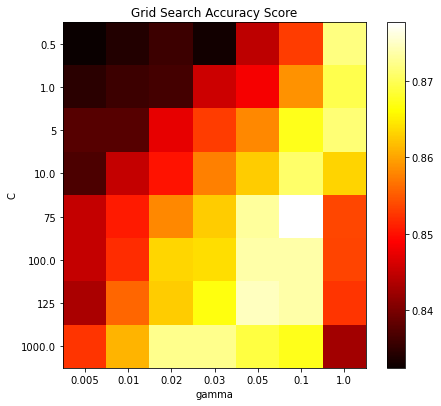

In [101]:
# I try to improve the grid search by investigating the part of the grid search with the highest accuracy

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range  = [0.5, 1.0, 5, 10.0, 75, 100.0, 125, 1000.0] # For regularization parameter C.
param_range2 = [0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 1.0]         # For scaling parameter gamma og rbf-kernel.
param_grid   = [{'svc__C': param_range, 'svc__kernel': ['linear']},
                {'svc__C': param_range, 'svc__gamma': param_range2, 'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)
print('Test accuracy: %.3f' % gs.score(X_test, y_test))

gs.cv_results_['mean_test_score'] 
scores = gs.cv_results_['mean_test_score'][len(param_range):].reshape(len(param_range),len(param_range2))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma') # 1/(softness of decision boundary), i.e. small = soft
plt.ylabel('C')     # 1/(size of support vector margin), i.e. large = tight margin
plt.colorbar()
plt.xticks(np.arange(len(param_range2)), param_range2)
plt.yticks(np.arange(len(param_range)), param_range)
plt.title('Grid Search Accuracy Score')
plt.show()

0.8811855500821018
{'svc__C': 125, 'svc__gamma': 0.08, 'svc__kernel': 'rbf'}
Test accuracy: 0.885


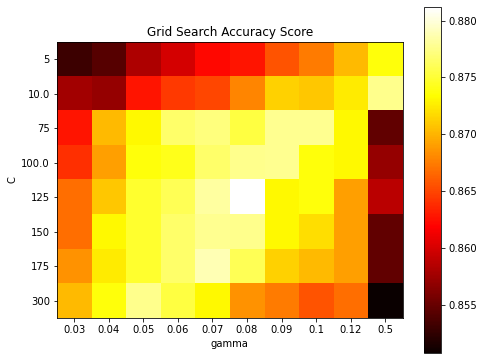

In [65]:
# Define the pipeline (scaling and classification method):
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
pipe_svc.get_params()

# Define ranges of parameter values:
param_range  = [5, 10.0, 75, 100.0, 125, 150, 175, 300] # For regularization parameter C.
param_range2 = [0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12, 0.5]         # For scaling parameter gamma og rbf-kernel.
param_grid   = [{'svc__C': param_range, 'svc__kernel': ['linear']},
                {'svc__C': param_range, 'svc__gamma': param_range2, 'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)
print('Test accuracy: %.3f' % gs.score(X_test, y_test))

gs.cv_results_['mean_test_score'] # There are 64 parameter combinations - averages over 10CV-segments.
scores = gs.cv_results_['mean_test_score'][len(param_range):].reshape(len(param_range),len(param_range2))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma') # 1/(softness of decision boundary), i.e. small = soft
plt.ylabel('C')     # 1/(size of support vector margin), i.e. large = tight margin
plt.colorbar()
plt.xticks(np.arange(len(param_range2)), param_range2)
plt.yticks(np.arange(len(param_range)), param_range)
plt.title('Grid Search Accuracy Score')
plt.show()

It appears I cannot get closer with this method. However, 0.885 is reasonably close to 0.89 that i have gotten earlier.

[[358   0   0]
 [  4 163  40]
 [  2  45 135]]


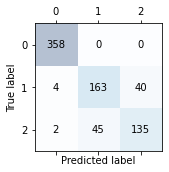

In [79]:
# Fit the pipeline and pedict the values
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
# Create a confusion matrix
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)
# Create the visual matrix
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

# It is clear that class 0 separates easily from 1 and 2, but class 1 and 2 has a hard time separating in this model.

### Appendix 

In [62]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from numpy import interp


raw_training_data_2 = pd.read_csv('train.csv')
train_df_2 = raw_training_data_2[~raw_training_data_2['target'].isin(['potentially_habitable'])]
X_2 = train_df_2.iloc[:, :6]
y_2 = train_df_2.iloc[:, -1]

X_2['growth_potential'] = X['growth_potential'].fillna(np.mean(X['growth_potential']))

le_2 = LabelEncoder()
y_2 = le_2.fit_transform(y_2)
print(le_2.classes_)
print(le_2.transform(['non_habitable', 'very_habitable']))

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.3, stratify=y_2, random_state=1337)
X_train_2.shape[0] # Shows the number of samples in the traning dataset.

['non_habitable' 'very_habitable']
[0 1]


1260

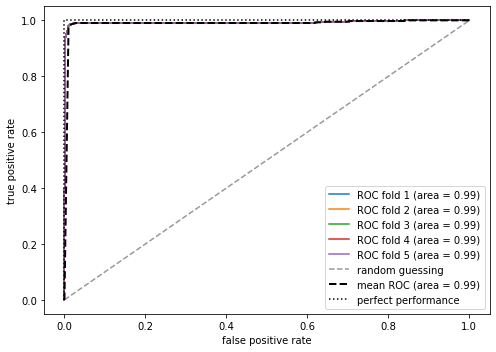

In [61]:
# Set up pipeline with scale, decomposer and classifyer
pipe_lr_2 = make_pipeline(StandardScaler(), PCA(n_components=5), LogisticRegression(random_state=1337))

# Cross-validation specification
cv = list(StratifiedKFold(n_splits=5).split(X_train_2, y_train_2))
#print(cv)

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

# Loop through folds of CV
for i, (train, test) in enumerate(cv):
    probas = pipe_lr_2.fit(X_train_2, y_train_2).predict_proba(X_train_2) # Predict probability of classes

    # False Positive and True Positive Rates (thresholds for the decision function)
    fpr, tpr, thresholds = roc_curve(y_train_2, probas[:, 1], pos_label=1)
    
    # Add to mean True Predictive Rate in a smoothed variant (interpolated)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')

# Average True Positive Rate
mean_tpr /= len(cv)
mean_tpr[0] = 0.0
mean_tpr[-1] = 1.0
# Average AUC
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

The logistic regression classifier we chose have a 99 % accuracy in its predictions. 
We see that all the prediction lines are far above the dotted line, which shows that our model beats random guessing by a landslide. 

One of the main reason for the high accuracy is the removal of the "potentially_habitable" value from
the target column. By removing one of the targets, the model becomes more certain in its predictions. Especially since the model could previously not separate two the classes. 

[[358   0]
 [  2 180]]


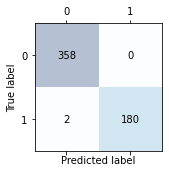

In [77]:
pipe_lr_2.fit(X_train_2, y_train_2)
y_pred_2 = pipe_lr_2.predict(X_test_2)
confmat = confusion_matrix(y_true=y_test_2, y_pred=y_pred_2)
print(confmat)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

In [94]:
# Submission 2 
sumbission_ready(y_pred2, 2)

In [ ]:
# Submission 3 
sumbission_ready(y_pred2, 3)

In [264]:
# Submission 4 
sumbission_ready(y_pred2, 4)

In [327]:
# Submission 5 
sumbission_ready(y_pred2_deli, 5)